#### Presence absence analysis of the DK0911 genome

Different level of analysis  
- mapping
- whole genome alignment
- synteny
- orthology  

both ways with
- genes
- TEs

#### What to get

- Pull in all the lowcov at different level and substract out the own files at the same level. Use bedtools subtract.
- Do some randomization for the lowcov and the WGA mapping. This can hopefully be used to test for specificty in losses. If not do a X-square or fisher exact test.
- Pull in all the TE files at the superfamily and family level to see what is missing in the different genomes from each other. Ask the question if certain subfamiles are more likely different.
- Maybe use LTRs to look for the divergence time. This could be great to see when they last had a common ancestor.

#### Usefull folders

- Warrior TE analysis: /home/benjamin/genome_assembly/Warrior/TE_analysis
- Pst_104_TE analysis: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis
- comparative coverage: /home/benjamin/genome_assembly/Warrior/TE_analysis


## Start with filtering the mapping files at the appropriate level

In [85]:
%matplotlib inline

In [2]:
import os
from pybedtools import BedTool
import pandas as pd
import scipy
import pandas as pd
import numpy as np # need for  stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from seaborn import boxenplot
import pybedtools

In [3]:
SRM_cov_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping'
SRM_cov_outdir = os.path.join(SRM_cov_dir, 'filtered')
SRM_cov_rand_outdir = os.path.join(SRM_cov_outdir, 'randomized')
DK0911_genome_file_fn = '/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file'
Pst_104E_genome_file_fn = \
'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_ph_ctg.genome_file'
if not os.path.exists(SRM_cov_outdir):
    os.mkdir(SRM_cov_outdir)
if not os.path.exists(SRM_cov_rand_outdir):
    os.mkdir(SRM_cov_rand_outdir)

In [4]:
#look at the mummer coverage as well
WGA_cov_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/mummer4/'
WGA_cov_rand_outdir = os.path.join(WGA_cov_dir, 'randomized')
if not os.path.exists(WGA_cov_rand_outdir):
    os.mkdir(WGA_cov_rand_outdir)
OUT_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/analysis'

In [5]:
###all the bedfiles
Pst_104E_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/Pst104E_annotations/'
Pst_104E_dict = {}
Pst_104E_dict['Busco'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.busco.gene.bed')
Pst_104E_dict['All_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.genes.gene.bed')
Pst_104E_dict['Secretome'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.secretome.gene.bed')
Pst_104E_dict['Ceffectors'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.ceffectors.gene.bed')
Pst_104E_dict['EffectorP'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.effectorp.gene.bed')
Pst_104E_dict['TE_superfamily'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')

In [6]:
###all the bedfiles
DK0911_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations/'
DK0911_dict = {}
DK0911_dict['Busco'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.busco.gene.bed')
DK0911_dict['All_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.genes.gene.bed')
DK0911_dict['Secretome'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.secretome.gene.bed')
DK0911_dict['Ceffectors'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['EffectorP'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['TE_superfamily'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')

In [7]:
def filter_bed(pairing):
    """Filter bedfiels by substracting one from the other and return resulting bed as dataframe.
    Input: Tripled pairing of abs file path target, reference, ouf filename."""
    traget_bed_fn = pairing[0]
    ref_bed_fn = pairing[1]
    out_fn = pairing[2]
    if not traget_bed_fn.split('.')[-1] == ref_bed_fn.split('.')[-1]:
        print('oh no!')
    traget_bed = BedTool(traget_bed_fn)
    ref_bed = BedTool(ref_bed_fn)
    filtered_bed = traget_bed.subtract(ref_bed).saveas(out_fn)
    pybedtools.cleanup()
    return filtered_bed.to_dataframe()

In [8]:
def non_covered_bases(df):
    """Calculate the coverage of a bed file provided as dataframe."""
    return sum(df['end'] - df['start'])

In [9]:
def randomize_bed(bed_in, genome_file_fn, out_dir, n=10):
    """Randomize a bedfile using shuffle of bedtools."""
    out_fn = os.path.join(out_dir, os.path.basename(bed_in).replace('.bed', '.random_%s.bed'))
    bed = BedTool(bed_in)
    for x in range(0, n):
        bed.shuffle(g=genome_file_fn).saveas(out_fn % x)
    pybedtools.cleanup()

In [51]:
def count_overlap_features(feature_bed, absence_bed, min_f_overlap):
    """Count the number of unqiue genes that intersect witht basence bedfile."""
    filtered_bed = BedTool(absence_bed)
    target_bed = BedTool(feature_bed)
    return target_bed.intersect(filtered_bed, f=min_f_overlap).to_dataframe().name.unique().shape[0]

In [11]:
def summary_dict_to_df(summary_dict, outer_index, inner_index):
    """Convert as summary dict with multiple keys and values of same length. To a multiindex dataframe."""
    assert(outer_index[0:int(len(outer_index)/2)] == outer_index[int(len(outer_index)/2):])
    assert(inner_index[0:int(len(inner_index)/2)] == inner_index[int(len(inner_index)/2):])
    df = pd.DataFrame.from_dict(summary_dict)
    if any([x for x in outer_index if x.startswith('0')]):
        df['Cut_off'] = [float(x.replace('0','.')) for x in outer_index[0:int(len(outer_index)/2)]]
    else:
        df['Cut_off'] = [float(x) for x in outer_index[0:int(len(outer_index)/2)]]
    df['Type'] = inner_index[0:int(len(inner_index)/2)]
    df.sort_values(['Cut_off', 'Type'], inplace = True)
    index = pd.MultiIndex.from_tuples(list(zip(df['Cut_off'] , df['Type'])), names=['Cut-off', 'Type'])
    df.index = index
    return df.loc[:, df.columns[:2]].copy()

In [12]:
def get_TE_sf_df(fn):    
    TE_header = ['Chrom', 'source', 'type', 'start', 'stop', 'score', 'strand', 'blank', 'superfamily']
    TE_df = pd.read_csv(fn, sep='\t', header = None, names=TE_header)
    TE_df["interval"] = TE_df.stop - TE_df.start + 1
    TE_sf_cov_df= TE_df.groupby('superfamily')['interval'].sum()
    return TE_sf_cov_df

In [13]:
def count_base_overlap_TE(feature_bed, absence_bed):
    """Count the number of basepair overlaps of a gff file with that intersect of 
    a basence bedfile.
    Returns a series containing gff attributes as index and sum of missing bases as value."""
    filtered_bed = BedTool(absence_bed)
    target_bed = BedTool(feature_bed)
    overlap_df = target_bed.intersect(filtered_bed).to_dataframe()
    overlap_df['interval'] = overlap_df.end - overlap_df.start + 1
    overlap_sf_cov_df = overlap_df.groupby('attributes')['interval'].sum()
    pybedtools.cleanup()
    return overlap_sf_cov_df

In [91]:
def plot_TE_cov_expect(genome, TE_random_dict, color, out_fn):
    TE_random_df = pd.concat(TE_random_dict, axis=1, sort=True)
    TE_random_df.fillna(0, inplace=True)
    rows = len(TE_random_df.index)//5
    f1, ax = plt.subplots(rows, 5, figsize=(20, 30))


    for key,y in zip(TE_random_df.index, product(range(0, rows), range(0,5))):
        overlap = TE_sf_cov_dict[genome][key]
        random_values = TE_random_df.loc[key,:]
        count = 0 
        for i in random_values:
            if i > overlap:
                count += 1
        p = count/len(random_values)

        two_side_p = 2*p

        if two_side_p > 1:
            two_side_p = round(2 - two_side_p, 3)
        else:
            two_side_p = round(two_side_p, 3)
        sns.violinplot(y=random_values, color=color, ax=ax[y[0], y[1]])
        ax[y[0], y[1]].axhline(y=overlap, color='r', linestyle='-')
        ax[y[0], y[1]].set_title(key, fontsize=16)
        ax[y[0], y[1]].set_yticklabels([])
        ax[y[0], y[1]].set_ylabel('')
        ax[y[0], y[1]].set_xlabel('p=' + str(two_side_p), fontsize=16)
        ax[y[0] ,0].set_ylabel('Number of overlapping bases', fontsize=16)
    plt.tight_layout()
    #f1.suptitle(os.path.basename(out_fn))
    plt.savefig(out_fn, dpi =300)
    return f1

In [15]:
from itertools import product

### Get some input values sorted

In [16]:
genome_size_dict = {}
genome_size_dict['DK0911'] = pd.read_csv(DK0911_genome_file_fn, sep='\t',header = None)[1].sum()
genome_size_dict['Pst_104E'] = pd.read_csv(Pst_104E_genome_file_fn, sep='\t',header = None)[1].sum()
TE_sf_cov_dict = {}
TE_sf_cov_dict['DK0911'] = get_TE_sf_df(DK0911_dict['TE_superfamily'])
TE_sf_cov_dict['Pst_104E'] = get_TE_sf_df(Pst_104E_dict['TE_superfamily'])

### This part looks at generating filtered bed files and random shuffled bed files for 0.3 cut-off

The 0.3 coverage cut-off is choosen based on the DK0911 BUSCOs being pretty stable until this coverage cut-off.

In [17]:
all_bed_fns = [os.path.join(SRM_cov_dir, x) for x in os.listdir(SRM_cov_dir) if x.endswith('bed') ] 

In [18]:
references = [x for x in all_bed_fns if os.path.basename(x).startswith('DK_0911_v04_ph_ctg.bwamem.DK0911_gDNA.RG.')\
              or  os.path.basename(x).startswith('Pst_104E_v13_ph_ctg.bwamem.Pst79_folder5.')]
references.sort()

targets = [x for x in all_bed_fns if x not in references]
targets.sort()

out_fns = [os.path.join(SRM_cov_outdir, os.path.basename(x).replace('bed','.filtered.bed')) for x in targets]

pairings = [x for x in zip(targets,references, out_fns)]

In [19]:
#filter the parings
for pair in pairings:
    filter_bed(pair)

In [20]:
print("This is the file that got randomized: %s\n\n" % pairings[0][2])
print("This is the file that got randomized: %s\n\n" % pairings[-8][2])

This is the file that got randomized: /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/DK_0911_v04_ph_ctg.bwamem.Pst79_TS.RG.mark_dup.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed


This is the file that got randomized: /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/Pst_104E_v13_ph_ctg.bwamem.DK0911_gDNA.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed




In [ ]:
#randomize the bedfiles of the lowcov targted. Yet first look at the results of fishers exact tests and
#pick the appropriate coveraged cut off
randomize_bed(pairings[-8][2], Pst_104E_genome_file_fn, SRM_cov_rand_outdir, n=5000)
randomize_bed(pairings[0][2], DK0911_genome_file_fn, SRM_cov_rand_outdir, n=5000)

### The next session compares the observed low coverage regions with different genes types in the two isolates
First the results are saved in a dictionary and then converted to a multiindex dataframe

In [52]:
Pst_104E_dict.keys()

dict_keys(['Ceffectors', 'Secretome', 'Busco', 'EffectorP', 'TE_superfamily', 'All_genes'])

In [76]:
keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']

In [53]:
Fishers_summary_dict = {}
Absence_summary_dict = {}
outer_index = [] #being the cut off
inner_index = [] #being the type of gene to look at
Fishers_summary_dict['DK0911'] = []
Fishers_summary_dict['Pst_104E'] = []
Absence_summary_dict['DK0911'] = []
Absence_summary_dict['Pst_104E'] = []
min_overlap = 1
keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
#pair[2] is the filtered lowcov file as reference
for pair in pairings:
    if os.path.basename(pair[2]).startswith('DK_0911'):
        expect_list = [count_overlap_features(DK0911_dict['All_genes'],pair[2],min_overlap) ,\
                       pd.read_csv(DK0911_dict['All_genes'], sep='\t').shape[0]]
        cut_off = os.path.basename(pair[2]).split('.')[-3].replace('lowcov', '')
        for key in keys:
            inner_index.append(key)
            outer_index.append(cut_off)
            test_list = [count_overlap_features(DK0911_dict[key],pair[2],min_overlap),\
                         pd.read_csv(DK0911_dict[key], sep='\t').shape[0]]
            Fishers_summary_dict['DK0911'].append(fisher_exact([test_list, expect_list])[1])
            Absence_summary_dict['DK0911'].append(count_overlap_features(DK0911_dict[key],pair[2],min_overlap))
    if os.path.basename(pair[2]).startswith('Pst_104E_v13_ph_ctg'):
        expect_list = [count_overlap_features(Pst_104E_dict['All_genes'],pair[2],min_overlap) ,\
                       pd.read_csv(Pst_104E_dict['All_genes'], sep='\t').shape[0]]
        cut_off = os.path.basename(pair[2]).split('.')[-3].replace('lowcov', '')
        for key in keys:
            inner_index.append(key)
            outer_index.append(cut_off)
            test_list = [count_overlap_features(Pst_104E_dict[key],pair[2],min_overlap),\
                         pd.read_csv(Pst_104E_dict[key], sep='\t').shape[0]]
            Fishers_summary_dict['Pst_104E'].append(fisher_exact([test_list, expect_list])[1])
            Absence_summary_dict['Pst_104E'].append(count_overlap_features(Pst_104E_dict[key],pair[2],min_overlap))

In [54]:
Fishers_df = summary_dict_to_df(Fishers_summary_dict, outer_index, inner_index)
Absence_df = summary_dict_to_df(Absence_summary_dict, outer_index, inner_index)

In [55]:
out_fn = os.path.join(OUT_dir, 'Lowcov_fisher_mo%s_df.tsv' % min_overlap)
Fishers_df.to_csv(out_fn, sep='\t')
Fishers_df

DK0911      Pst_104E
Cut-off Type                                  
0.10    All_genes   1.000000e+00  1.000000e+00
        Busco       2.095908e-12  5.452251e-10
        Ceffectors  3.326086e-02  5.835868e-02
        EffectorP   3.326086e-02  4.918653e-02
        Secretome   1.436923e-06  5.983780e-02
0.20    All_genes   1.000000e+00  1.000000e+00
        Busco       6.310735e-17  3.119838e-08
        Ceffectors  1.857437e-01  1.044646e-01
        EffectorP   1.857437e-01  7.858847e-03
        Secretome   2.056203e-07  1.289605e-01
0.25    All_genes   1.000000e+00  1.000000e+00
        Busco       5.577766e-14  8.647120e-07
        Ceffectors  1.985610e-01  8.101202e-02
        EffectorP   1.985610e-01  6.307230e-03
        Secretome   3.146984e-06  1.803824e-01
0.30    All_genes   1.000000e+00  1.000000e+00
        Busco       1.388569e-17  3.204988e-06
        Ceffectors  9.441717e-02  1.500362e-01
        EffectorP   9.441717e-02  3.009929e-03
        Secretome   7.890919e-08  3.212371e-01
0.35    All_genes   1.000000e+00  1.000000e+00
        Busco       2.021682e-24  2.206528e-05
        Ceffectors  4.462727e-01  1.137832e-01
        EffectorP   4.462727e-01  2.889571e-03
        Secretome   1.298732e-06  4.272960e-01
0.40    All_genes   1.000000e+00  1.000000e+00
        Busco       6.157951e-23  4.794413e-05
        Ceffectors  6.863553e-01  1.536092e-02
        EffectorP   6.863553e-01  1.189007e-02
        Secretome   7.661602e-06  1.909251e-01
0.45    All_genes   1.000000e+00  1.000000e+00
        Busco       4.695157e-26  1.145350e-04
        Ceffectors  6.297686e-01  1.450041e-02
        EffectorP   6.297686e-01  1.922877e-02
        Secretome   9.148189e-05  1.647942e-01
0.50    All_genes   1.000000e+00  1.000000e+00
        Busco       4.695157e-26  3.866778e-05
        Ceffectors  6.297686e-01  3.993055e-02
        EffectorP   6.297686e-01  3.175162e-03
        Secretome   9.148189e-05  4.806112e-01

In [57]:
out_fn = os.path.join(OUT_dir, 'Lowcov_absence_mo%s_df.tsv' % min_overlap)
Absence_df.to_csv(out_fn, sep='\t')
Absence_df

DK0911  Pst_104E
Cut-off Type                        
0.10    All_genes      724      2394
        Busco           13       126
        Ceffectors      25       244
        EffectorP       25       189
        Secretome       55       327
0.20    All_genes      864      2844
        Busco           12       167
        Ceffectors      36       298
        EffectorP       36       233
        Secretome       66       400
0.25    All_genes      705      3310
        Busco           10       211
        Ceffectors      29       347
        EffectorP       29       269
        Secretome       54       473
0.30    All_genes      909      3253
        Busco           13       211
        Ceffectors      36       347
        EffectorP       36       269
        Secretome       69       473
0.35    All_genes     1310      3675
        Busco           19       251
        Ceffectors      62       391
        EffectorP       62       301
        Secretome      119       541
0.40    All_genes     1154      4107
        Busco           15       288
        Ceffectors      57       419
        EffectorP       57       324
        Secretome      106       592
0.45    All_genes     1452      4030
        Busco           22       286
        Ceffectors      72       410
        EffectorP       72       315
        Secretome      148       578
0.50    All_genes     1452      4475
        Busco           22       316
        Ceffectors      72       468
        EffectorP       72       360
        Secretome      148       664

### Look over the different filtered lowcov regions and caculate the amount of uncovered bases

In [58]:
#loop over the different lowcoverage file, filter them and count the total bases of lowcoverage
summary_dict = {}
summary_dict['DK0911'] = []
summary_dict['Pst_104E'] = []
index = []
for pair in pairings:
    non_cov_bases = non_covered_bases(filter_bed(pair))
    cut_off = pair[2].split('.')[-3].replace('lowcov','')
    index.append(cut_off)
    if pair[2].split('.')[2].startswith('Pst79_'):
        summary_dict['DK0911'].append(non_cov_bases)
    elif pair[2].split('.')[2].startswith('DK0911_'):
        summary_dict['Pst_104E'].append(non_cov_bases)

length = len(index) 
index[0:int(length/2)] == index[int(length/2):]
df = pd.DataFrame.from_dict(summary_dict)
df.index = [float(x.replace('0','.')) for x in index[0:int(length/2)]]
df.sort_index(inplace=True)
#check on Pst_104E mapping on DK0911
out_fn = os.path.join(OUT_dir, 'Lowcov_missing_bases_df.tsv')
df.to_csv(out_fn, sep='\t')
df

,DK0911,Pst_104E
0.10,6363272,20821493
0.20,8207965,23931160
0.25,7258527,27039841
0.30,9478055,26696752
0.35,13378670,29523551
0.40,12340369,32520559
0.45,15598968,31975598
0.50,15598968,35131544


### Now look do the permutation tests at the 0.3 lowcov value for all gene groups in both isolates

In [59]:
Pst_random_dict_lowcov = {}
DK0911_random_dict_lowcov = {}

In [62]:
#loop over all gene files
#for each gene file do the whole permuation test and safe it as part of a dictionary
Pst_104E_random_fn_lowcov = [os.path.join(SRM_cov_rand_outdir, x) for x in os.listdir(SRM_cov_rand_outdir) if x.startswith('Pst')]
Pst_104E_random_fn_lowcov.sort()
DK0911_random_fn_lowcov = [os.path.join(SRM_cov_rand_outdir, x) for x in os.listdir(SRM_cov_rand_outdir) if x.startswith('DK')]
DK0911_random_fn_lowcov.sort()
min_overlap = 1.0
for key in keys:
    Pst_random_dict_lowcov[key] = []
    for rand_fn in Pst_104E_random_fn_lowcov:
        Pst_random_dict_lowcov[key].append(count_overlap_features(Pst_104E_dict[key], rand_fn, min_overlap))
    DK0911_random_dict_lowcov[key] = []
    for rand_fn in DK0911_random_fn_lowcov:
        DK0911_random_dict_lowcov[key].append(count_overlap_features(DK0911_dict[key], rand_fn, min_overlap))

In [63]:
pallete = [sns.color_palette('colorblind')[x] for x in [0,1]]
reference_bed_fn = pairings[-8][2]
columns = len(keys)

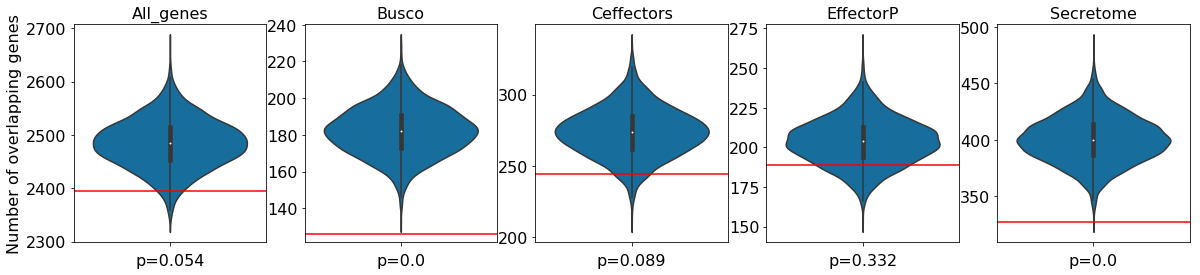

In [64]:
reference_bed_fn = pairings[-8][2]
f1, ax = plt.subplots(1, columns, figsize=(20, 4))
for n, key in enumerate(keys):
    overlap = count_overlap_features(Pst_104E_dict[key],reference_bed_fn, min_overlap)
    random_values = Pst_random_dict_lowcov[key]
    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)
    sns.violinplot(y=random_values, color=pallete[0], ax=ax[n])
    ax[n].axhline(y=overlap, color='r', linestyle='-')
    ax[n].set_title(key, fontsize=16)
    ax[n].set_xlabel('p=' + str(two_side_p), fontsize=16)
    ax[0].set_ylabel('Number of overlapping genes', fontsize=16)
    out_fn = os.path.join(OUT_dir, 'Pst104E_noncovered_%s_lowcov01_mo%s.facett.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300) 

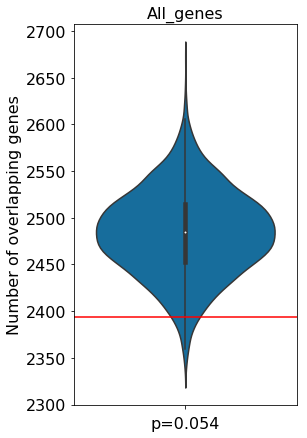

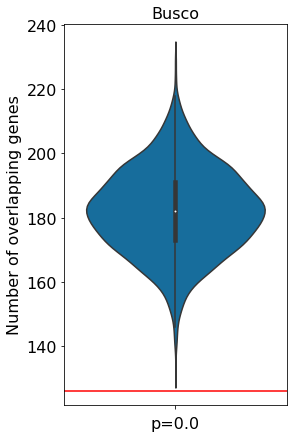

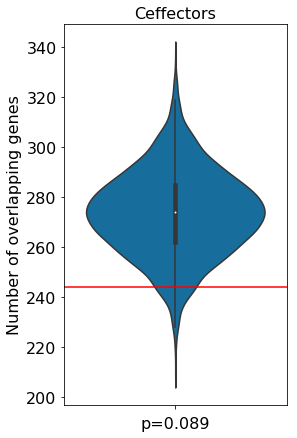

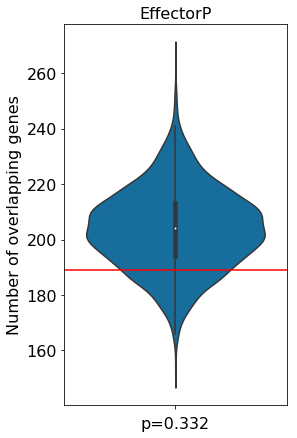

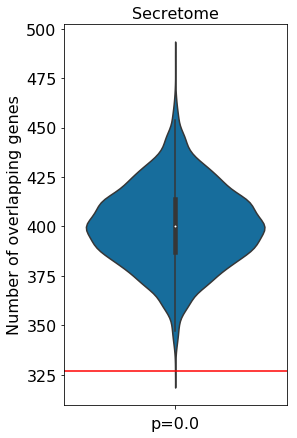

In [65]:
reference_bed_fn = pairings[-8][2]
for key in keys:
    overlap = count_overlap_features(Pst_104E_dict[key],reference_bed_fn, min_overlap)
    random_values = Pst_random_dict_lowcov[key]

    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)


    f, ax = plt.subplots(figsize=(4, 7))
    plt.style.use('fast')
    sns.violinplot(y=random_values, color=pallete[0])
    plt.axhline(y=overlap, color='r', linestyle='-')
    plt.title(key, fontsize=16)
    plt.ylabel('Number of overlapping genes', fontsize=16)
    plt.xlabel('p=' + str(two_side_p), fontsize=16)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    out_fn = os.path.join(OUT_dir, 'Pst104E_noncovered_%s_lowcov01_mo%s.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300)

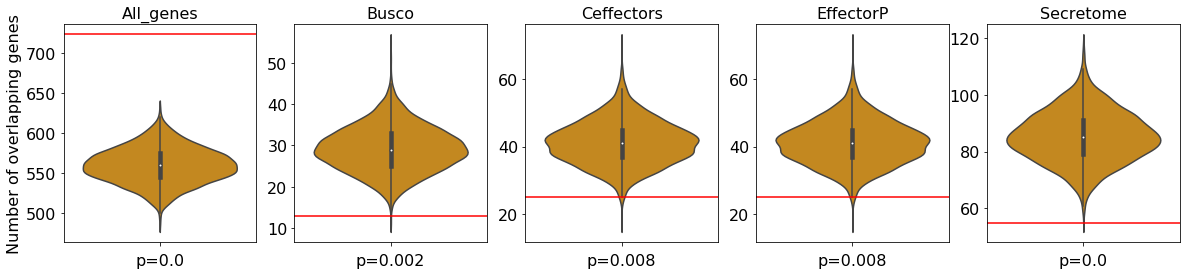

In [66]:
reference_bed_fn = pairings[0][2]
columns = len(keys)
f1, ax = plt.subplots(1, columns, figsize=(20, 4))


for n, key in enumerate(keys):
    overlap = count_overlap_features(DK0911_dict[key],reference_bed_fn, min_overlap)
    random_values = DK0911_random_dict_lowcov[key]
    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)
    sns.violinplot(y=random_values, color=pallete[1], ax=ax[n])
    ax[n].axhline(y=overlap, color='r', linestyle='-')
    ax[n].set_title(key, fontsize=16)
    ax[n].set_xlabel('p=' + str(two_side_p), fontsize=16)
    ax[0].set_ylabel('Number of overlapping genes', fontsize=16)
    out_fn = os.path.join(OUT_dir, 'DK0911_noncovered_%s_lowcov01_mo%s.facett.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300) 

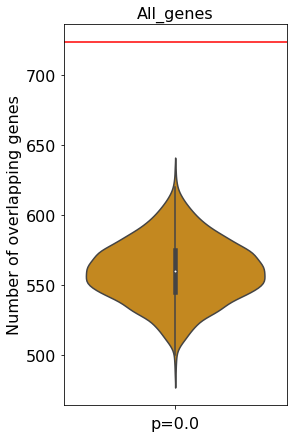

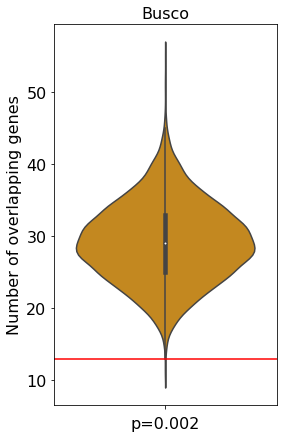

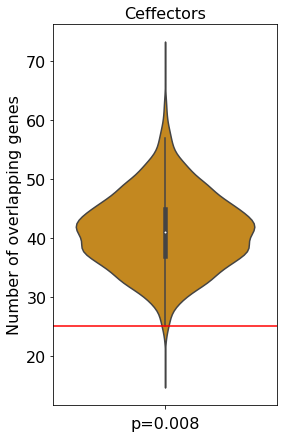

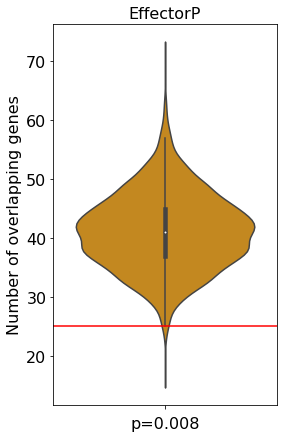

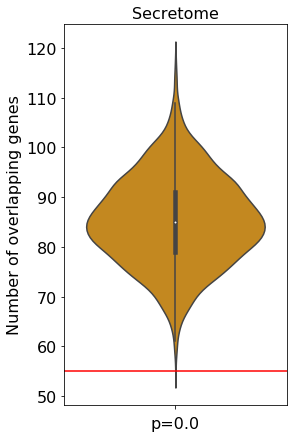

In [67]:
reference_bed_fn = pairings[0][2]
for key in keys:
    overlap = count_overlap_features(DK0911_dict[key],reference_bed_fn, min_overlap)
    random_values = DK0911_random_dict_lowcov[key]

    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)



    f, ax = plt.subplots(figsize=(4, 7))
    plt.style.use('fast')
    sns.violinplot(y=random_values, color=pallete[1])
    plt.axhline(y=overlap, color='r', linestyle='-')
    plt.title(key, fontsize=16)
    plt.ylabel('Number of overlapping genes', fontsize=16)
    plt.xlabel('p=' + str(two_side_p), fontsize=16)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    out_fn = os.path.join(OUT_dir, 'DK0911_noncovered_%s_lowcov01_mo%s.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300)

There doesn't seem anything specific about any gene family when looking for coverage of the mapping and what is missing. All seem to be significantly enriched.

### To-do

* look at the coverage files and the mapping files in igv and see if they line up.
    * done that and they looked just fine in case of DK0911 mapping onto Pst104E
* look at the coverage plots that are part of the het cov plotting
* genes that are not covered by Pst_104E reads by DK0911 could be genes related to sexual reproduction or infection of the host
* check into the overlap of genes that are not covered in both methods (lowcov01 and WGA95) and orthofinder. See if there is anything special in terms of length, expression, or function.
* check if there is non-random overlap between TE superfamilies and lowcov or WGA95 do this on the base overlap basis. If anything sticks out maybe look into family level and such.
* consider doing the absence presence polymorphism on the gene level. For all genes count how often they are totally absent <- this doesn't work as the size of real observations is 1.
* check if from the absent genes of of DK0911 in Pst104E are often both pairs of the allele or singletons


### Orthology analysis

* look into the singleton levels in other fungal species. Similar?

## Now look at mummer whole genome alignment in the same way

In [68]:
mummer_files = [os.path.join(WGA_cov_dir, x) for x in os.listdir(WGA_cov_dir) if x.endswith('.bed')]
mummer_files.sort()

In [69]:
Fishers_summary_dict = {}
Absence_summary_dict = {}
outer_index = [] #being the cut off
inner_index = [] #being the type of gene to look at
Fishers_summary_dict['DK0911'] = []
Fishers_summary_dict['Pst_104E'] = []
Absence_summary_dict['DK0911'] = []
Absence_summary_dict['Pst_104E'] = []
min_overlap = 1.0
for m_fn in mummer_files:
    if os.path.basename(m_fn).startswith('DK_0911'):
        expect_list = [count_overlap_features(DK0911_dict['All_genes'],m_fn,min_overlap) ,\
                       pd.read_csv(DK0911_dict['All_genes'], sep='\t').shape[0]]
        cut_off = os.path.basename(m_fn).split('.')[-3].replace('deltafilter_i', '').replace('mu0g_','')
        for key in keys:
            inner_index.append(key)
            outer_index.append(cut_off)
            test_list = [count_overlap_features(DK0911_dict[key],m_fn,min_overlap),\
                         pd.read_csv(DK0911_dict[key], sep='\t').shape[0]]
            Fishers_summary_dict['DK0911'].append(fisher_exact([test_list, expect_list])[1])
            Absence_summary_dict['DK0911'].append(count_overlap_features(DK0911_dict[key],m_fn,min_overlap))
    if os.path.basename(m_fn).startswith('Pst_104E_v13_ph_ctg'):
        expect_list = [count_overlap_features(Pst_104E_dict['All_genes'],m_fn,min_overlap) ,\
                       pd.read_csv(Pst_104E_dict['All_genes'], sep='\t').shape[0]]
        cut_off = os.path.basename(m_fn).split('.')[-3].replace('deltafilter_i', '').replace('mu0g_','')
        for key in keys:
            inner_index.append(key)
            outer_index.append(cut_off)
            test_list = [count_overlap_features(Pst_104E_dict[key],m_fn,min_overlap),\
                         pd.read_csv(Pst_104E_dict[key], sep='\t').shape[0]]
            Fishers_summary_dict['Pst_104E'].append(fisher_exact([test_list, expect_list])[1])
            Absence_summary_dict['Pst_104E'].append(count_overlap_features(Pst_104E_dict[key],m_fn,min_overlap))

In [70]:
Fishers_df = summary_dict_to_df(Fishers_summary_dict, outer_index, inner_index)
Absence_df = summary_dict_to_df(Absence_summary_dict, outer_index, inner_index)

In [71]:
out_fn = os.path.join(OUT_dir, 'WGA_fisher_df.tsv')
Fishers_df.to_csv(out_fn, sep='\t')
Fishers_df

DK0911      Pst_104E
Cut-off Type                              
70.0    All_genes   1.000000  1.000000e+00
        Busco       0.000017  4.601254e-15
        Ceffectors  1.000000  5.513537e-03
        EffectorP   1.000000  4.608696e-01
        Secretome   0.037733  3.946967e-03
80.0    All_genes   1.000000  1.000000e+00
        Busco       0.000017  4.601254e-15
        Ceffectors  1.000000  5.513537e-03
        EffectorP   1.000000  4.608696e-01
        Secretome   0.037733  3.946967e-03
85.0    All_genes   1.000000  1.000000e+00
        Busco       0.000017  4.601254e-15
        Ceffectors  1.000000  5.513537e-03
        EffectorP   1.000000  4.608696e-01
        Secretome   0.037733  3.946967e-03
90.0    All_genes   1.000000  1.000000e+00
        Busco       0.000017  3.588639e-15
        Ceffectors  1.000000  6.231400e-03
        EffectorP   1.000000  4.342227e-01
        Secretome   0.037733  4.461713e-03
95.0    All_genes   1.000000  1.000000e+00
        Busco       0.000046  1.719902e-13
        Ceffectors  0.923490  3.478190e-03
        EffectorP   0.923490  5.002761e-01
        Secretome   0.018395  2.438179e-03
96.0    All_genes   1.000000  1.000000e+00
        Busco       0.000012  4.032448e-11
        Ceffectors  0.851965  2.201587e-03
        EffectorP   0.851965  5.726985e-01
        Secretome   0.029680  4.224420e-03
97.0    All_genes   1.000000  1.000000e+00
        Busco       0.000094  4.268641e-06
        Ceffectors  1.000000  2.093214e-03
        EffectorP   1.000000  6.948678e-01
        Secretome   0.162495  4.572518e-02
98.0    All_genes   1.000000  1.000000e+00
        Busco       0.000293  1.565639e-01
        Ceffectors  0.943618  1.182754e-02
        EffectorP   0.943618  1.239965e-01
        Secretome   0.964157  7.933231e-01
99.0    All_genes   1.000000  1.000000e+00
        Busco       0.755995  1.130160e-01
        Ceffectors  0.051098  2.983810e-02
        EffectorP   0.051098  9.907005e-03
        Secretome   0.702317  2.399763e-01
100.0   All_genes   1.000000  1.000000e+00
        Busco       0.899560  9.662264e-01
        Ceffectors  0.953178  3.873449e-11
        EffectorP   0.953178  9.741524e-01
        Secretome   0.970235  1.000000e+00

In [72]:
out_fn = os.path.join(OUT_dir, 'WGA_absence_df.tsv')
Absence_df.to_csv(out_fn, sep='\t')
Absence_df

DK0911  Pst_104E
Cut-off Type                        
70.0    All_genes      536      1973
        Busco           18        79
        Ceffectors      28       185
        EffectorP       28       142
        Secretome       57       248
80.0    All_genes      536      1973
        Busco           18        79
        Ceffectors      28       185
        EffectorP       28       142
        Secretome       57       248
85.0    All_genes      536      1973
        Busco           18        79
        Ceffectors      28       185
        EffectorP       28       142
        Secretome       57       248
90.0    All_genes      536      1980
        Busco           18        79
        Ceffectors      28       186
        EffectorP       28       143
        Secretome       57       250
95.0    All_genes      553      2084
        Busco           20        91
        Ceffectors      28       194
        EffectorP       28       149
        Secretome       57       261
96.0    All_genes      584      2249
        Busco           20       111
        Ceffectors      32       209
        EffectorP       32       159
        Secretome       62       287
97.0    All_genes      674      2800
        Busco           28       178
        Ceffectors      35       266
        EffectorP       35       194
        Secretome       81       383
98.0    All_genes     1032      4551
        Busco           53       380
        Ceffectors      55       465
        EffectorP       55       337
        Secretome      146       689
99.0    All_genes     3012      9088
        Busco          258       878
        Ceffectors     187       973
        EffectorP      187       689
        Secretome      420      1447
100.0   All_genes    25840     30166
        Busco         2178      2735
        Ceffectors    1373      2951
        EffectorP     1373      2029
        Secretome     3688      4625

In [73]:
#loop over the different lowcoverage file, filter them and count the total bases of lowcoverage
summary_dict = {}
summary_dict['DK0911'] = []
summary_dict['Pst_104E'] = []
index = []
for m_fn in mummer_files:
    non_cov_bases = non_covered_bases(pd.read_csv(m_fn, sep='\t', header=None, names=['chrom', 'start', 'end']))
    cut_off = os.path.basename(m_fn).split('.')[-3].replace('deltafilter_i', '').replace('mu0g_','')
    index.append(cut_off)
    if m_fn.split('.')[1].startswith('Pst_'):
        summary_dict['DK0911'].append(non_cov_bases)
    elif m_fn.split('.')[1].startswith('DK_0911_'):
        summary_dict['Pst_104E'].append(non_cov_bases)

length = len(index) 
index[0:int(length/2)] == index[int(length/2):]
df = pd.DataFrame.from_dict(summary_dict)
df.index = [float(x) for x in index[0:int(length/2)]]
df.sort_index(inplace=True)
#check on Pst_104E mapping on DK0911
out_fn = os.path.join(OUT_dir, 'WGA_missing_bases_df.tsv')
df.to_csv(out_fn, sep='\t')
df

,DK0911,Pst_104E
70.0,4044908,16452382
80.0,4044908,16452382
85.0,4044908,16452382
90.0,4047543,16458336
95.0,4125467,16912063
96.0,4290256,17499925
97.0,4679529,19618957
98.0,6215870,26365995
99.0,14281977,45756967
100.0,126112766,156396447


In [74]:
print("This is the file that got randomized: %s\n\n" % mummer_files[-5])
print("This is the file that got randomized: %s\n\n" % mummer_files[5])

This is the file that got randomized: /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/mummer4/Pst_104E_v13_ph_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed


This is the file that got randomized: /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/mummer4/DK_0911_v04_ph_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed




In [ ]:
#randomize the bedfiles of the WGA targted. Yet first look at the results of fishers exact tests and
#pick the appropriate coveraged cut off
randomize_bed(mummer_files[-5], Pst_104E_genome_file_fn, WGA_cov_rand_outdir, n=5000)
randomize_bed(mummer_files[5], DK0911_genome_file_fn, WGA_cov_rand_outdir, n=5000)

In [77]:
#loop over all gene files
#for each gene file do the whole permuation test and safe it as part of a dictionary
Pst_104E_random_fn_WGA = [os.path.join(WGA_cov_rand_outdir, x) for x in os.listdir(WGA_cov_rand_outdir) if x.startswith('Pst')]
Pst_104E_random_fn_WGA.sort()
DK0911_random_fn_WGA = [os.path.join(WGA_cov_rand_outdir, x) for x in os.listdir(WGA_cov_rand_outdir) if x.startswith('DK')]
DK0911_random_fn_WGA.sort()

min_overlap = 1.0
for key in keys:
    Pst_random_dict_WGA[key] = []
    for rand_fn in Pst_104E_random_fn_WGA:
        Pst_random_dict_WGA[key].append(count_overlap_features(Pst_104E_dict[key], rand_fn, min_overlap))
    DK0911_random_dict_WGA[key] = []
    for rand_fn in DK0911_random_fn_WGA:
        DK0911_random_dict_WGA[key].append(count_overlap_features(DK0911_dict[key], rand_fn, min_overlap))

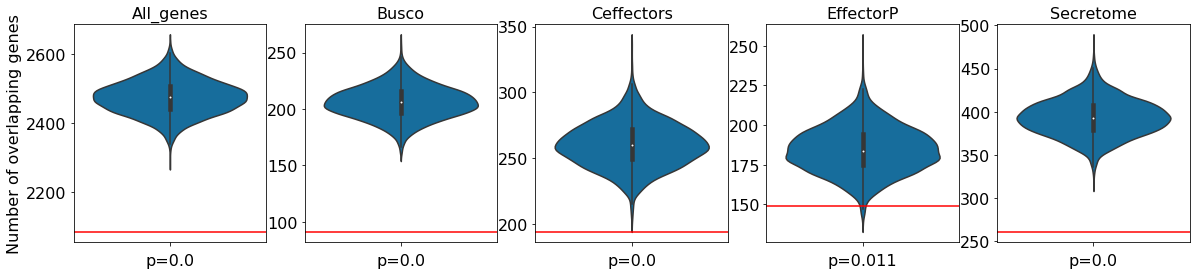

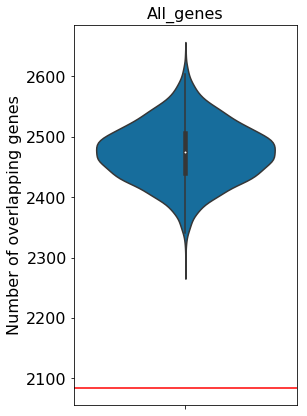

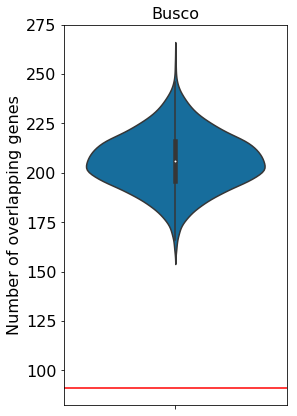

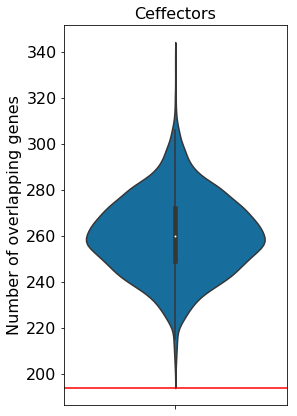

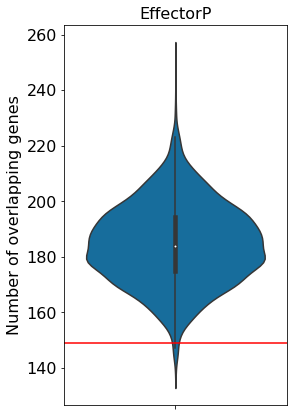

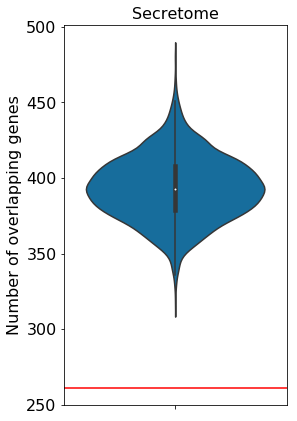

In [78]:
reference_bed_fn = mummer_files[-5]
columns = len(keys)
f1, ax = plt.subplots(1, columns, figsize=(20, 4))


for n, key in enumerate(keys):
    overlap = count_overlap_features(Pst_104E_dict[key],reference_bed_fn, min_overlap)
    random_values = Pst_random_dict_WGA[key]
    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)
    sns.violinplot(y=random_values, color=pallete[0], ax=ax[n])
    ax[n].axhline(y=overlap, color='r', linestyle='-')
    ax[n].set_title(key, fontsize=16)
    ax[n].set_xlabel('p=' + str(two_side_p), fontsize=16)
    ax[0].set_ylabel('Number of overlapping genes', fontsize=16)
    out_fn = os.path.join(OUT_dir, 'Pst104E_noncovered_%s_WGAmi95_mo%s.facett.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300)
for key in keys:
    overlap = count_overlap_features(Pst_104E_dict[key],reference_bed_fn, min_overlap)
    random_values = Pst_random_dict_WGA[key]

    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)
        
    f, ax = plt.subplots(figsize=(4, 7))
    plt.style.use('fast')
    sns.violinplot(y=random_values, color=pallete[0])
    plt.axhline(y=overlap, color='r', linestyle='-')
    plt.title(key, fontsize=16)
    plt.ylabel('Number of overlapping genes', fontsize=16)

    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    out_fn = os.path.join(OUT_dir, 'Pst104E_noncovered_%s_WGAmi95_mo%s.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300)

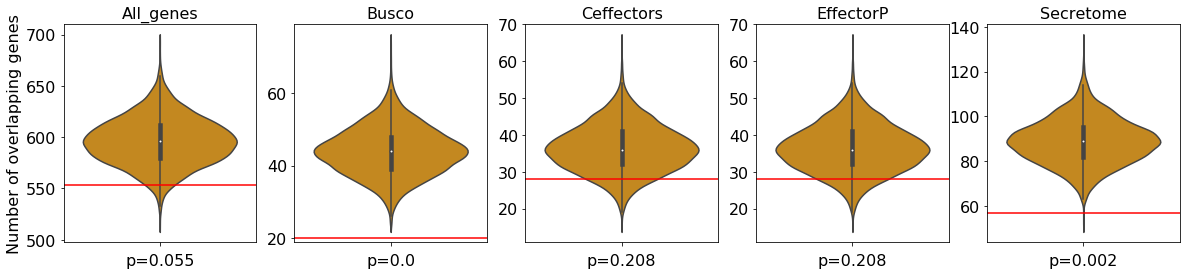

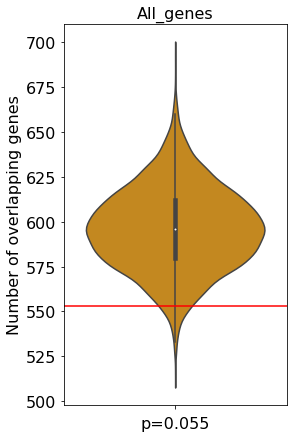

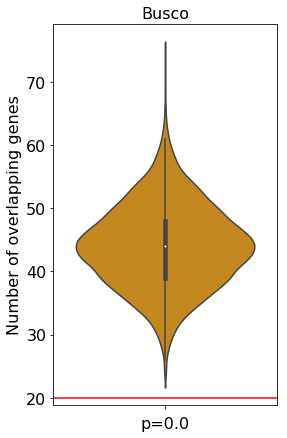

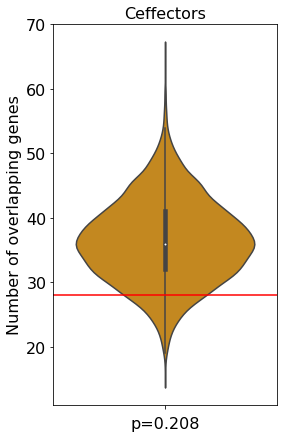

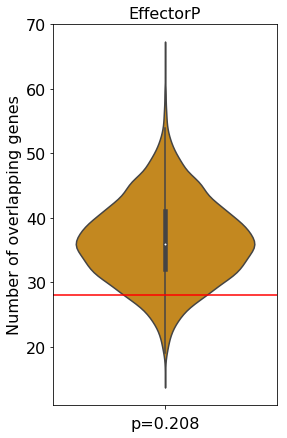

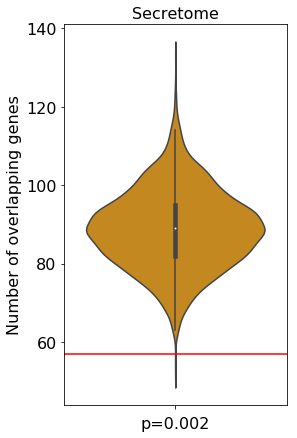

In [79]:
reference_bed_fn = mummer_files[5]
columns = len(keys)
f1, ax = plt.subplots(1, columns, figsize=(20, 4))


for n, key in enumerate(keys):
    overlap = count_overlap_features(DK0911_dict[key],reference_bed_fn, min_overlap)
    random_values = DK0911_random_dict_WGA[key]
    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)
    sns.violinplot(y=random_values, color=pallete[1], ax=ax[n])
    ax[n].axhline(y=overlap, color='r', linestyle='-')
    ax[n].set_title(key, fontsize=16)
    ax[n].set_xlabel('p=' + str(two_side_p), fontsize=16)
    ax[0].set_ylabel('Number of overlapping genes', fontsize=16)
    out_fn = os.path.join(OUT_dir, 'DK0911_noncovered_%s_WGAmi95_mo%s.facett.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300)    



for key in keys:
    overlap = count_overlap_features(DK0911_dict[key],reference_bed_fn, min_overlap)
    random_values = DK0911_random_dict_WGA[key]

    count = 0 
    for i in random_values:
        if i > overlap:
            count += 1
    p = count/len(random_values)
    
    two_side_p = 2*p
    
    if two_side_p > 1:
        two_side_p = round(2 - two_side_p, 3)



    f, ax = plt.subplots(figsize=(4, 7))
    plt.style.use('fast')
    sns.violinplot(y=random_values, color=pallete[1])
    plt.axhline(y=overlap, color='r', linestyle='-')
    plt.title(key, fontsize=16)
    plt.ylabel('Number of overlapping genes', fontsize=16)
    plt.xlabel('p=' + str(two_side_p), fontsize=16)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    out_fn = os.path.join(OUT_dir, 'DK0911_noncovered_%s_WGAmi95_mo%s.png' % (key,min_overlap))
    plt.savefig(out_fn, dpi =300)
        

### To-Do

* look at transposable elements. Think about sliglthly different analysis including superfamily and family level

In [ ]:
#loop over all gene files
#for each gene file do the whole permuation test and safe it as part of a dictionary
Pst_104E_random_fn_lowcov = [os.path.join(SRM_cov_rand_outdir, x) for x in os.listdir(SRM_cov_rand_outdir) if x.startswith('Pst')]
Pst_104E_random_fn_lowcov.sort()
DK0911_random_fn_lowcov = [os.path.join(SRM_cov_rand_outdir, x) for x in os.listdir(SRM_cov_rand_outdir) if x.startswith('DK')]
DK0911_random_fn_lowcov.sort()

DK0911_random_dict_lowcov['TE_superfamily'] = []
Pst_random_dict_lowcov['TE_superfamily'] = []
for rand_fn in DK0911_random_fn_lowcov[:2500]:
    DK0911_random_dict_lowcov['TE_superfamily'].append(count_base_overlap_TE(DK0911_dict['TE_superfamily'], rand_fn))
for rand_fn in Pst_104E_random_fn_lowcov[:2500]:
    #print(rand_fn)
    Pst_random_dict_lowcov['TE_superfamily'].append(count_base_overlap_TE(Pst_104E_dict['TE_superfamily'], rand_fn))
pybedtools.cleanup()

In [ ]:
#loop over all gene files
#for each gene file do the whole permuation test and safe it as part of a dictionary
Pst_104E_random_fn_WGA = [os.path.join(WGA_cov_rand_outdir, x) for x in os.listdir(WGA_cov_rand_outdir) if x.startswith('Pst')]
Pst_104E_random_fn_WGA.sort()
DK0911_random_fn_WGA = [os.path.join(WGA_cov_rand_outdir, x) for x in os.listdir(WGA_cov_rand_outdir) if x.startswith('DK')]
DK0911_random_fn_WGA.sort()
Pst_random_dict_WGA['TE_superfamily'] = []
DK0911_random_dict_WGA['TE_superfamily'] = []
for rand_fn in DK0911_random_fn_WGA[:2500]:
    DK0911_random_dict_WGA['TE_superfamily'].append(count_base_overlap_TE(DK0911_dict['TE_superfamily'], rand_fn))
for rand_fn in Pst_104E_random_fn_WGA[:2500]:
    Pst_random_dict_WGA['TE_superfamily'].append(count_base_overlap_TE(Pst_104E_dict['TE_superfamily'], rand_fn))

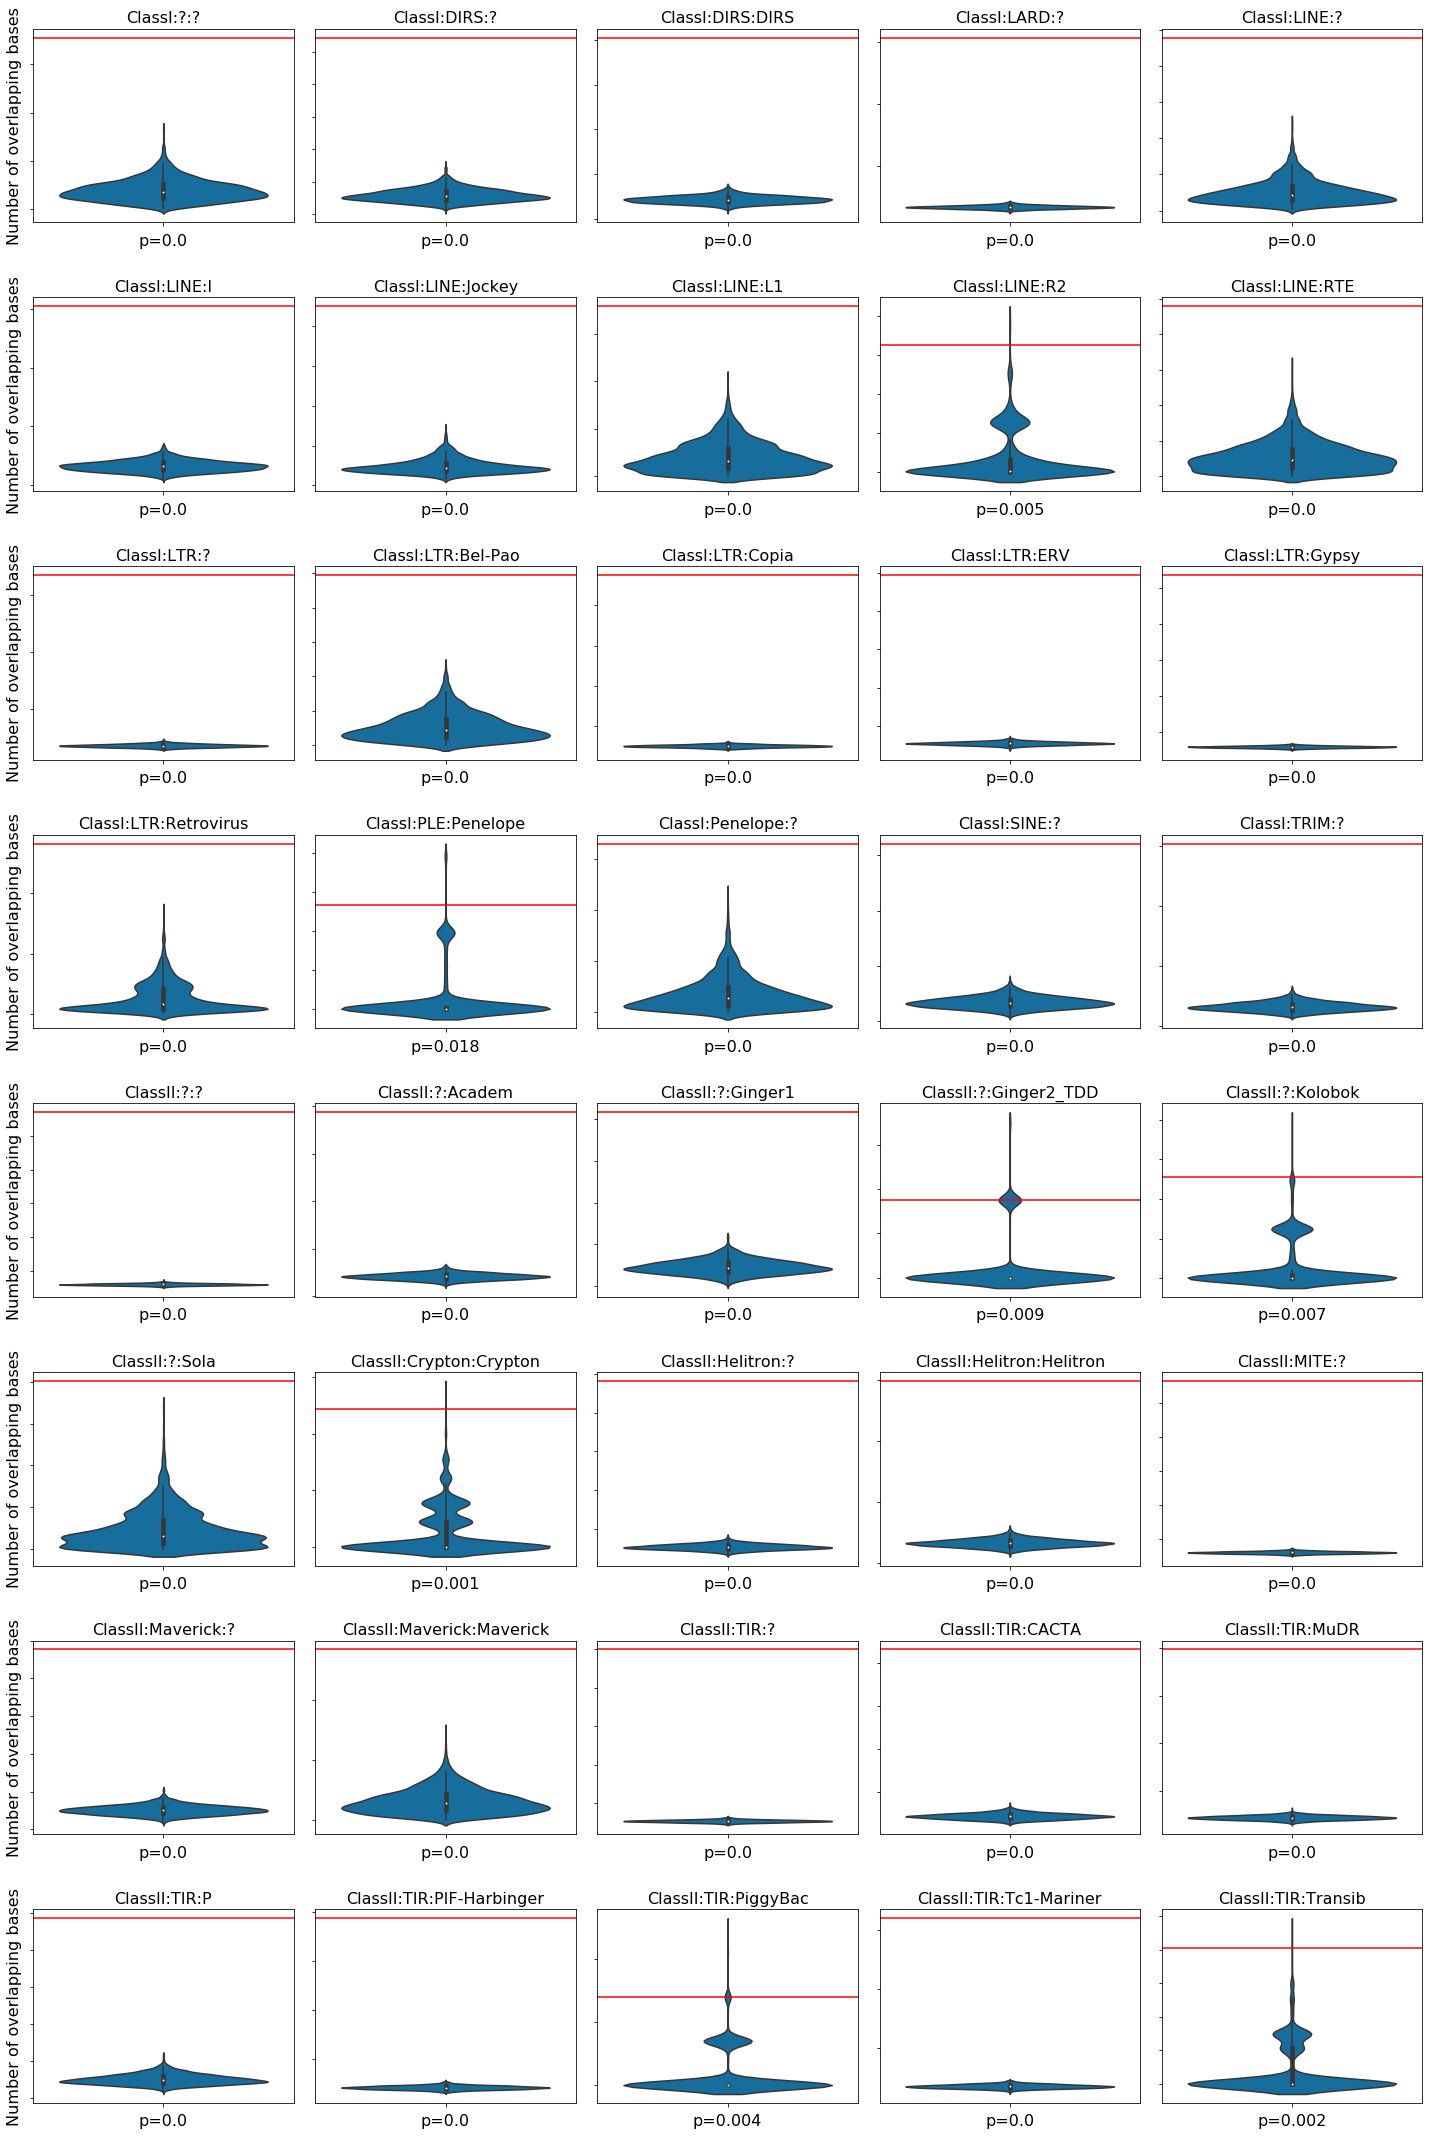

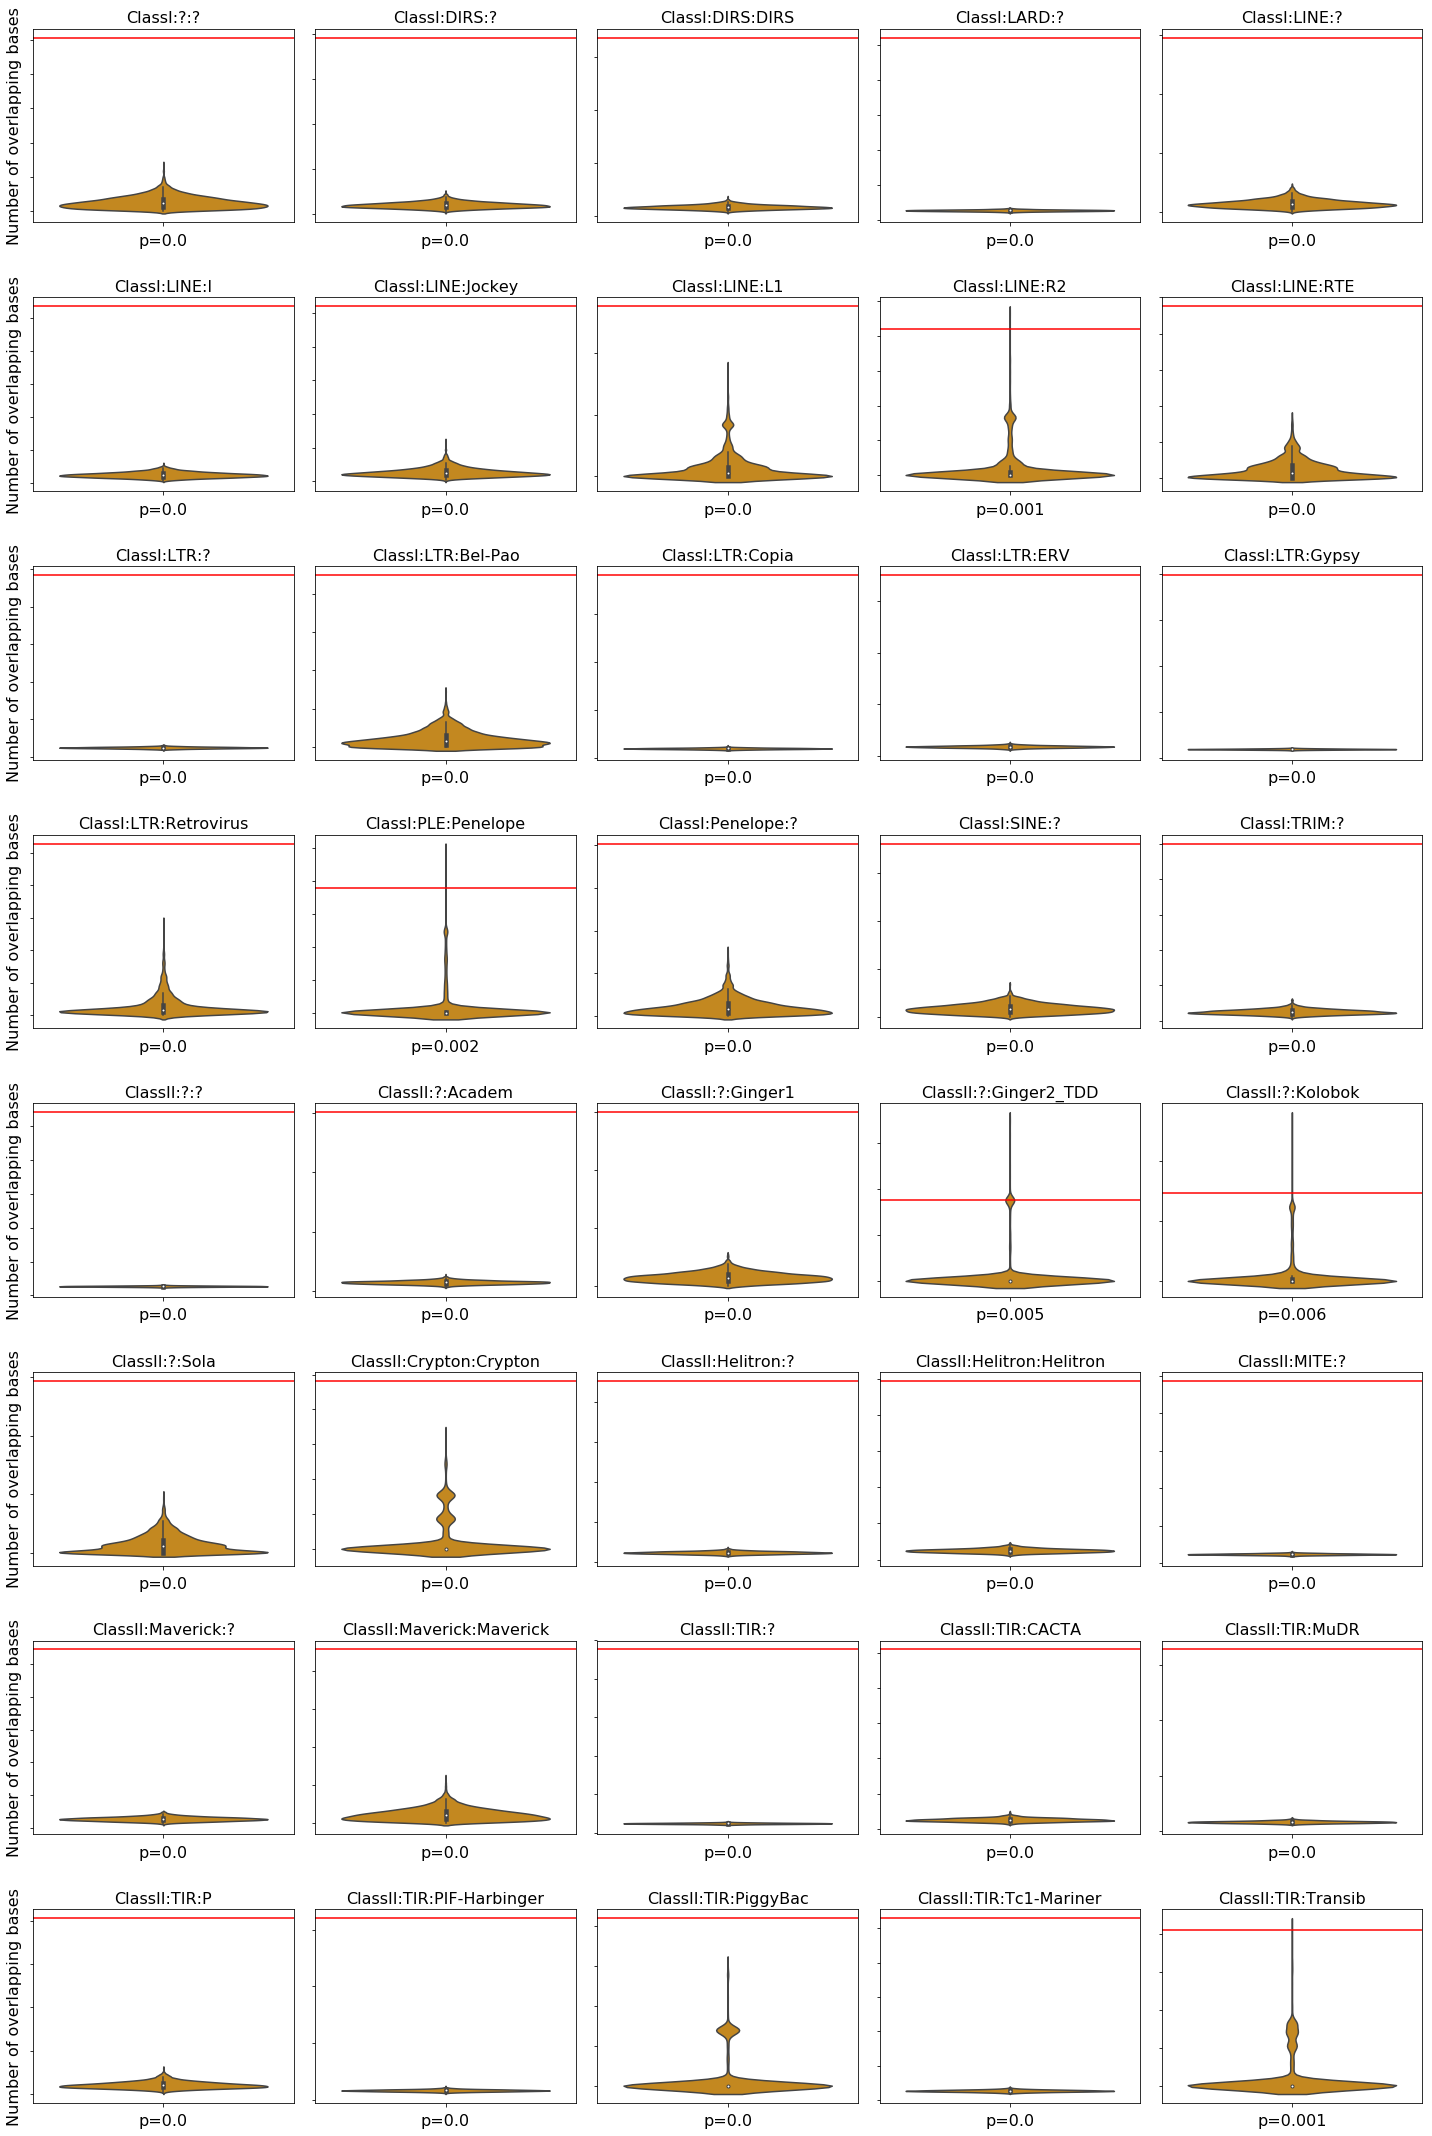

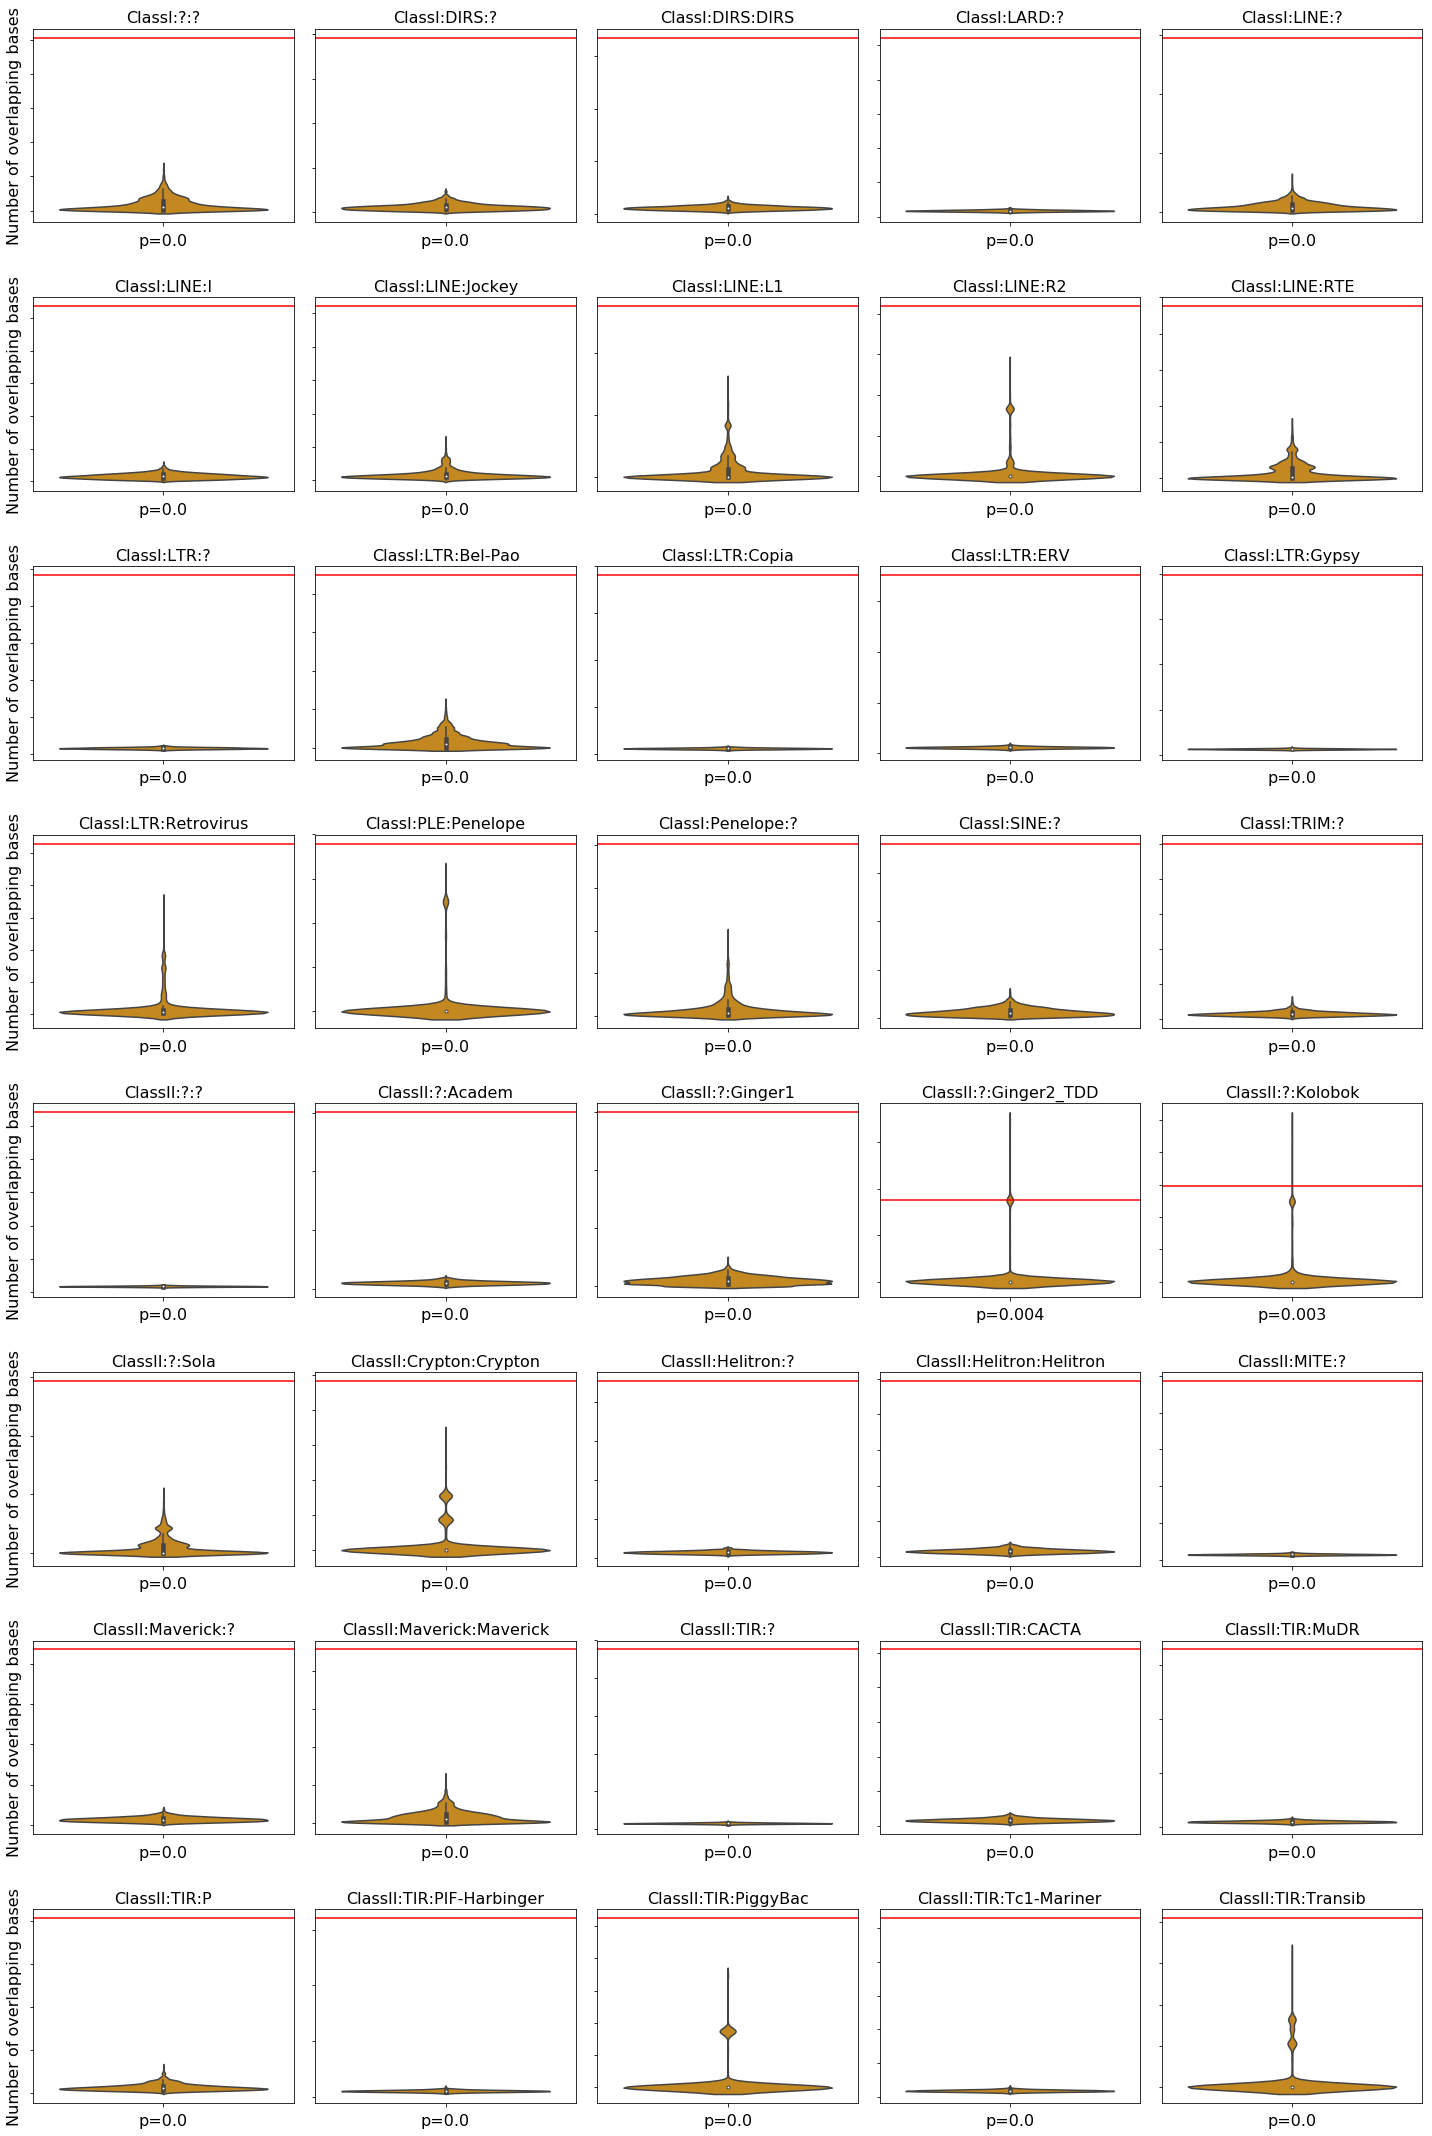

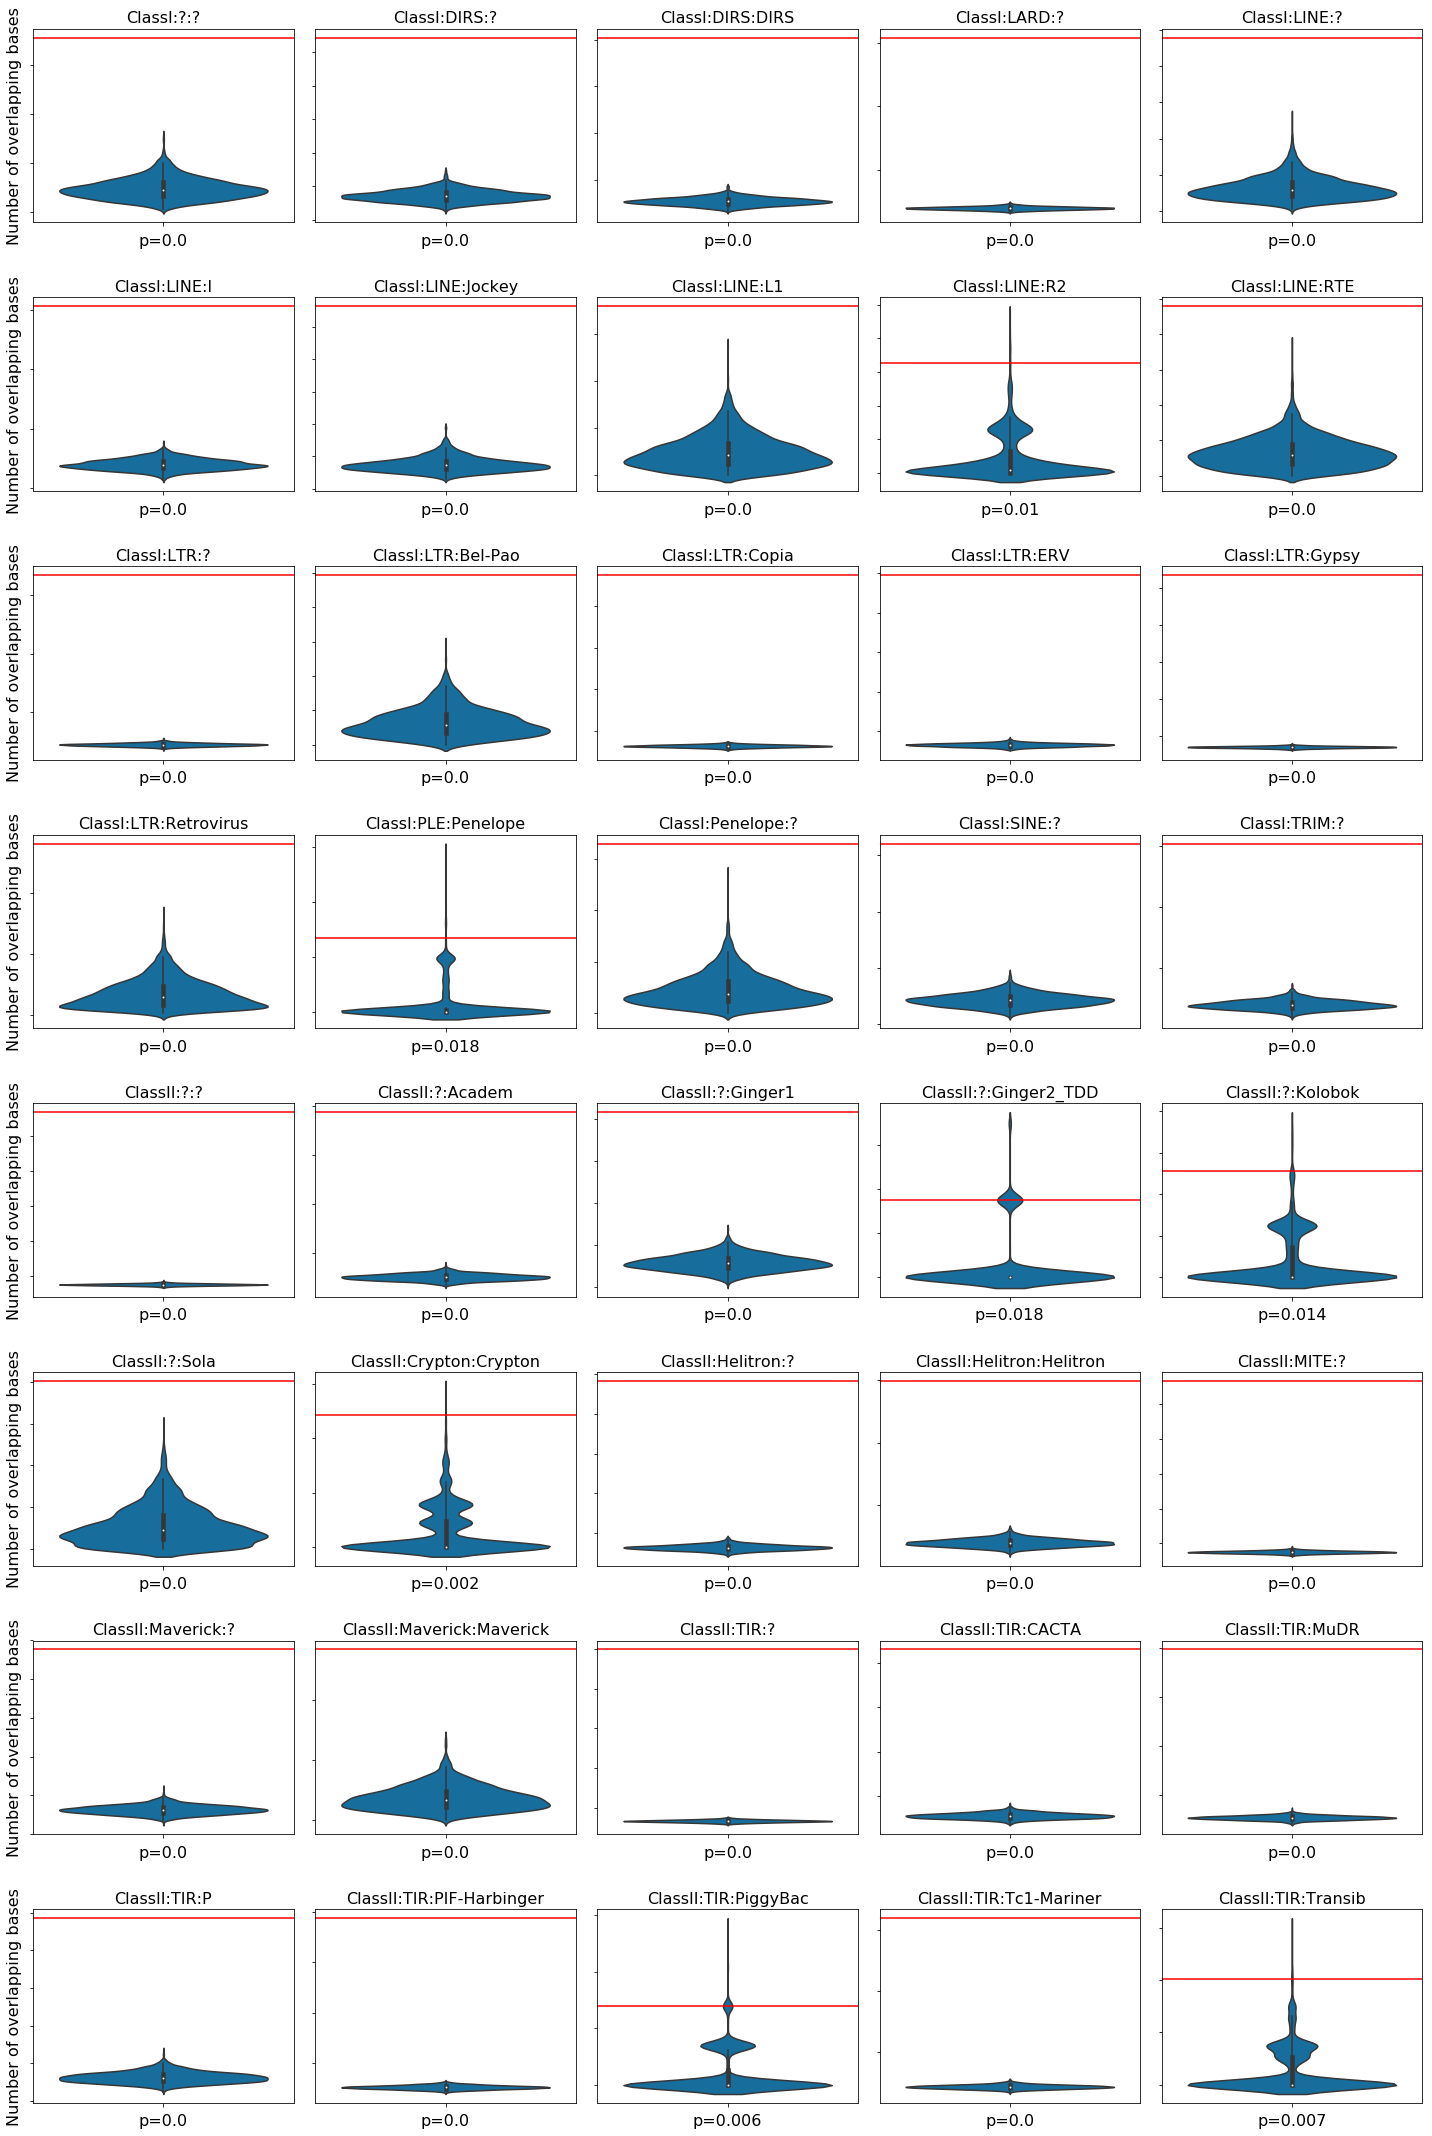

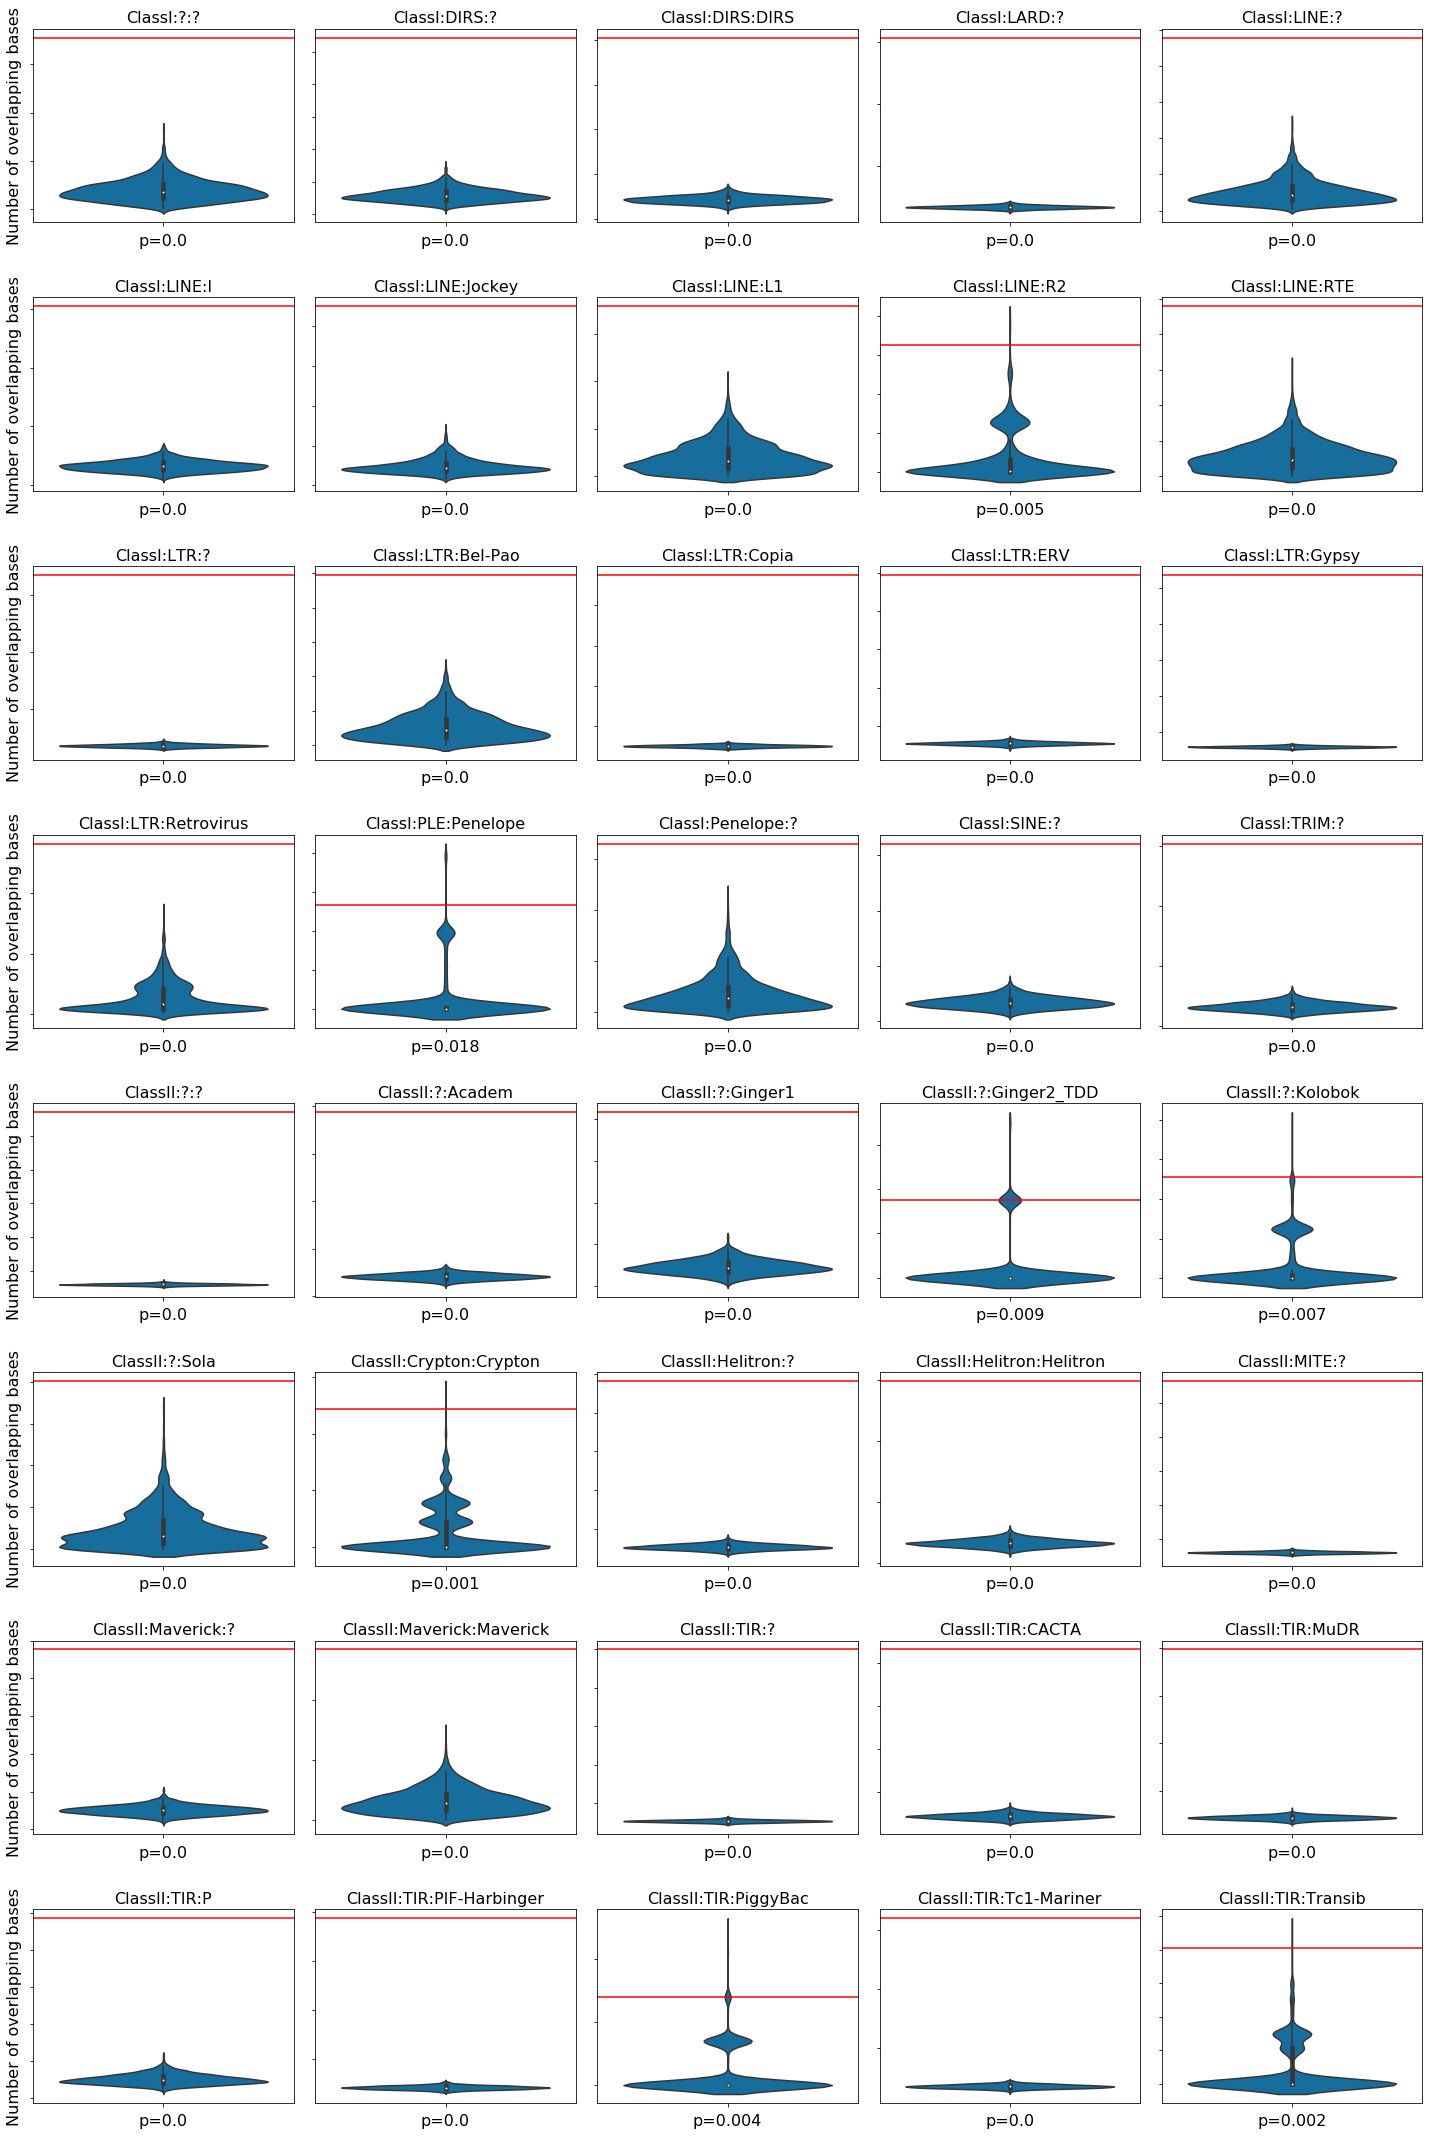

In [92]:
out_fn = os.path.join(OUT_dir, 'DK0911_noncovered_TE_superfamily_lowcov01_mo.facett.png' )
plot_TE_cov_expect('DK0911', DK0911_random_dict_lowcov['TE_superfamily'], pallete[1], out_fn)

out_fn = os.path.join(OUT_dir, 'DK0911_noncovered_TE_superfamily_WGAmi95.facett.png' )
plot_TE_cov_expect('DK0911', DK0911_random_dict_WGA['TE_superfamily'],pallete[1], out_fn)

#Pst104E
out_fn = os.path.join(OUT_dir, 'Pst104E_noncovered_TE_superfamily_lowcov01.facett.png')
plot_TE_cov_expect('Pst_104E', Pst_random_dict_lowcov['TE_superfamily'],pallete[0], out_fn)

out_fn = os.path.join(OUT_dir, 'Pst104E_noncovered_TE_superfamily_WGAmi95.facett.png')
plot_TE_cov_expect('Pst_104E', Pst_random_dict_WGA['TE_superfamily'],pallete[0], out_fn)

In [84]:
print("hello")

hello
